<H1>Prédire le prix d'un logement<H1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

In [2]:
from fastapi.middleware.cors import CORSMiddleware
origins = [
    "http://localhost.tiangolo.com", "https://localhost.tiangolo.com",
    "http://localhost", "http://127.0.0.1:5500", "http://localhost:8000", "http://localhost:8000/house_price/","http://localhost:8888"
]

Le dataset utilisé a été trouvé sur Kaggle à cet adresse: https://www.kaggle.com/datasets/shree1992/housedata. 

In [3]:
df = pd.read_csv('data.csv')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


On peut voir qu'il est composé de 4.600 entrées et de 18 colonnes numériques et catégorielles. Il n'y a pas de valeurs null. Comme il y a des valeurs numériques, nous vérifierons plus tard s'il y a des valeurs à 0 qui pourraient être considérées comme null.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

En annexe du rapport, vous trouverez la description/définition de chaque nom de colonne.

In [5]:
for column in df:
    print(f'{column} : {df[column].nunique()} valeur(s) différente(s)')

date : 70 valeur(s) différente(s)
price : 1741 valeur(s) différente(s)
bedrooms : 10 valeur(s) différente(s)
bathrooms : 26 valeur(s) différente(s)
sqft_living : 566 valeur(s) différente(s)
sqft_lot : 3113 valeur(s) différente(s)
floors : 6 valeur(s) différente(s)
waterfront : 2 valeur(s) différente(s)
view : 5 valeur(s) différente(s)
condition : 5 valeur(s) différente(s)
sqft_above : 511 valeur(s) différente(s)
sqft_basement : 207 valeur(s) différente(s)
yr_built : 115 valeur(s) différente(s)
yr_renovated : 60 valeur(s) différente(s)
street : 4525 valeur(s) différente(s)
city : 44 valeur(s) différente(s)
statezip : 77 valeur(s) différente(s)
country : 1 valeur(s) différente(s)


Nous décidons de supprimer les colonnes date, country, street, city et statezip arbitrairement pour le dataframe de visualisation.

In [6]:
data_viz=df.drop(columns=['date', 'country', 'street', 'city', 'statezip'])

Nous rajoutons une colonne year dans laquelle nous stockerons la valeur maximale entre yr_built et yr_renovated afin de n'avoir que les années les plus récentes dans le modèle. Puis nous supprimons les colonnes yr_built et yr_renovated qui ne serviront plus.

In [7]:
data_viz = data_viz.assign(year=0)

In [8]:
def year_fusion(data):
    data['year'] = data[['yr_built','yr_renovated']].max(axis=1)

In [9]:
year_fusion(data_viz)
data_viz=data_viz.drop(columns=['yr_built', 'yr_renovated'])
data_viz.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,year
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,2005
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1992


<h2>Visualisation<h2>

In [10]:
def regression_viz(data):
    for i, col in enumerate(data.columns):
        plt.figure(i)
        sns.regplot(x=data.columns[i], y="price", data=data_viz)


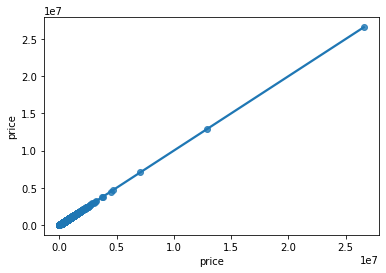

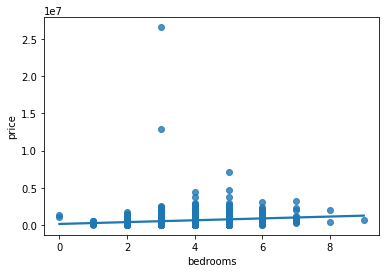

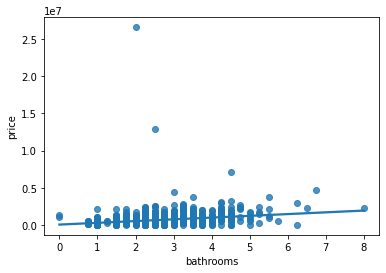

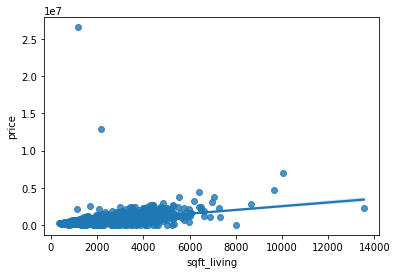

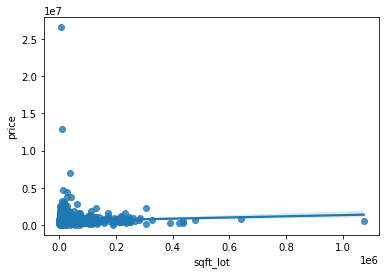

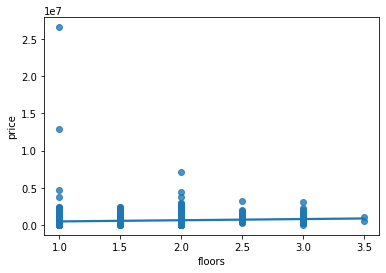

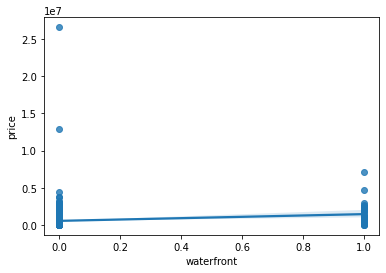

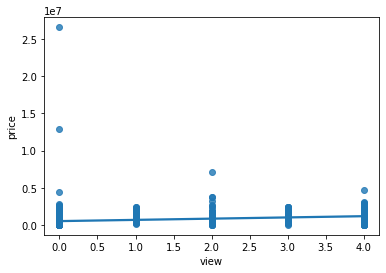

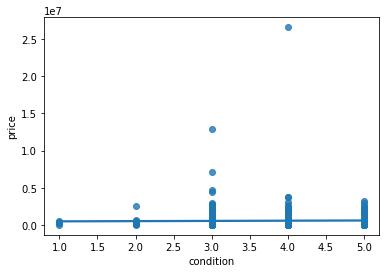

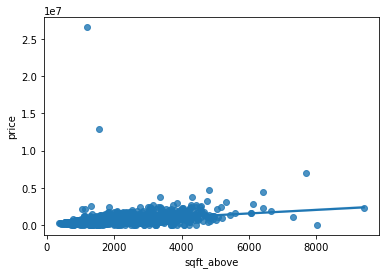

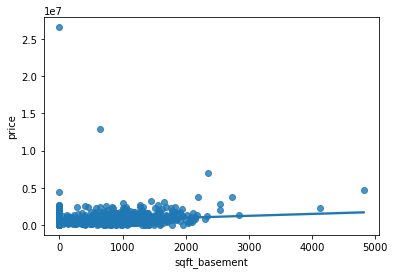

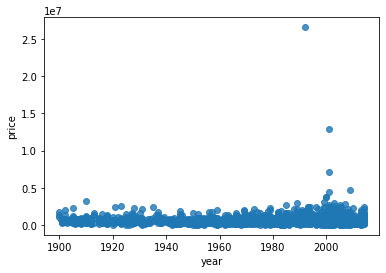

In [11]:
regression_viz(data_viz)

Sur ces graphiques nous remarquons des outliers qui sont supprimés dans la cellule suivante.

In [12]:
drop_line_sqft = data_viz[data_viz['sqft_basement'] > 4000].index
data_viz.drop(drop_line_sqft , inplace=True)

drop_line_price = data_viz[data_viz['price'] > 1000000].index
data_viz.drop(drop_line_price , inplace=True)

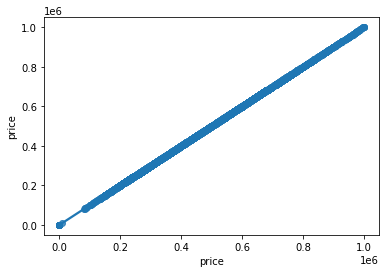

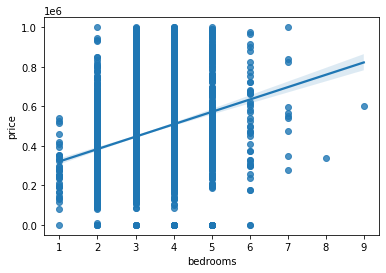

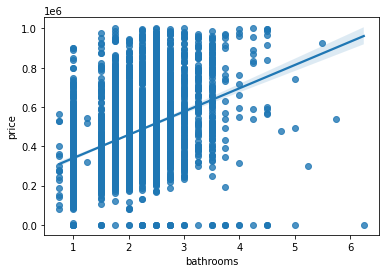

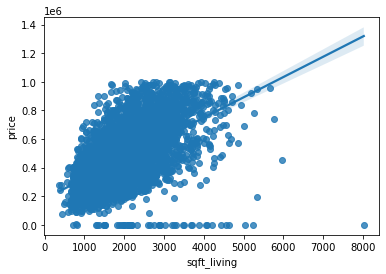

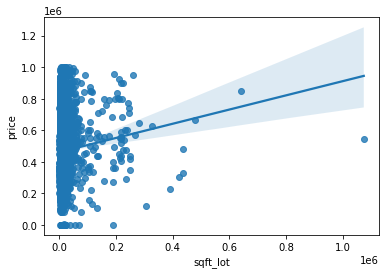

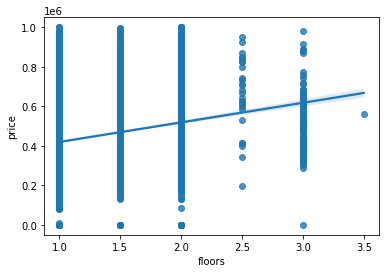

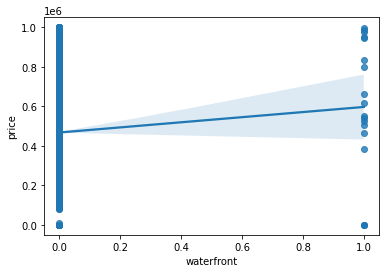

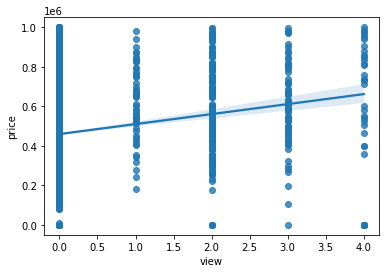

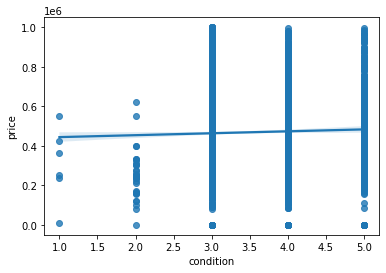

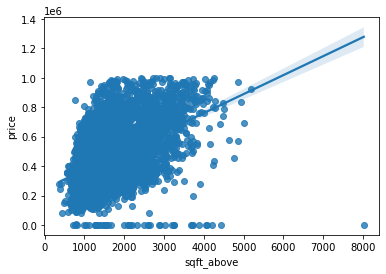

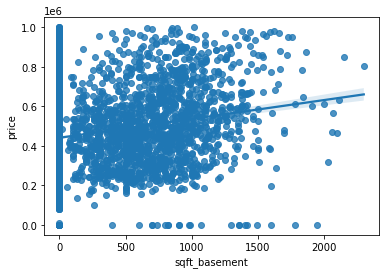

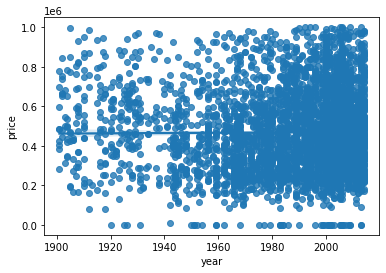

In [13]:
regression_viz(data_viz)

A présent il apparaît plus clairement que notre colonne <i>price</i> contient des valeurs à 0. Cette colonne allant devenir notre <i>y</i> pour la prédiction, il est donc nécessaire de supprimer les lignes correspondantes.

In [14]:
data_viz['price'].value_counts().sort_values

<bound method Series.sort_values of 0.0         49
300000.0    42
400000.0    31
600000.0    29
450000.0    29
            ..
375900.0     1
718000.0     1
222400.0     1
272500.0     1
220600.0     1
Name: price, Length: 1517, dtype: int64>

In [15]:
drop_zero_price = data_viz[data_viz['price'] == 0].index
data_viz.drop(drop_zero_price , inplace=True)

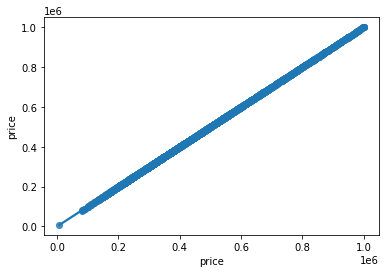

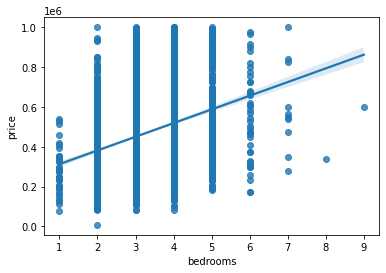

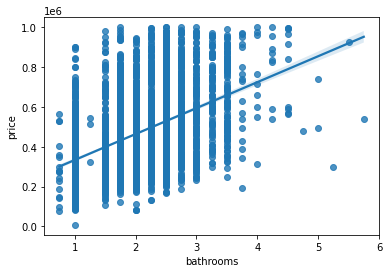

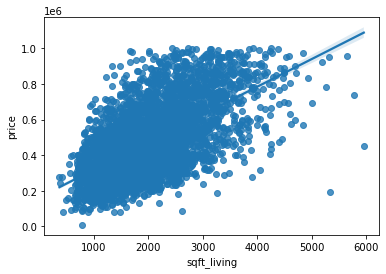

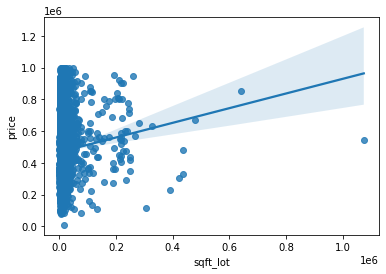

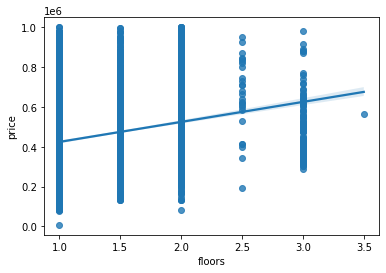

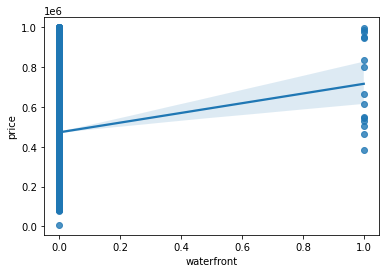

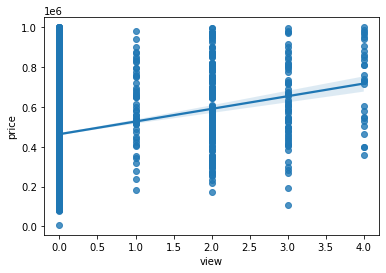

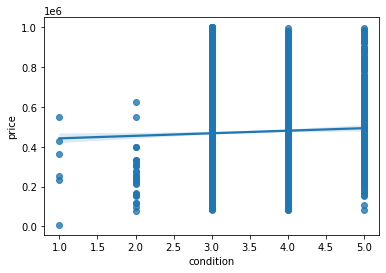

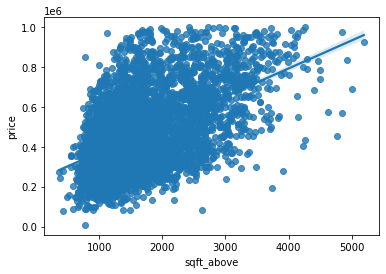

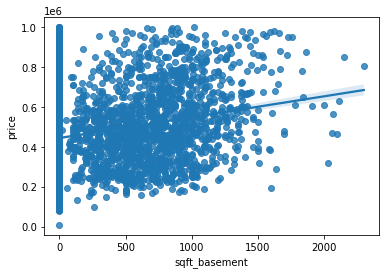

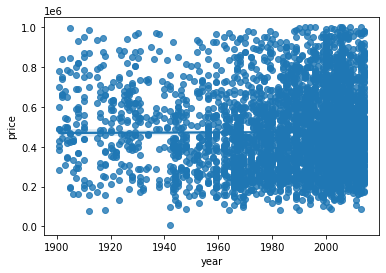

In [16]:
regression_viz(data_viz)

Maintenant on peut voir une corrélation entre les différentes features et le prix. Nous allons supprimer <i>condition</i> et <i>year</i> qui semblent n'avoir qu'un faible impact sur le prix.

In [17]:
data_viz = data_viz.drop(columns=['condition', 'year'])
data_viz.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,1340,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,1930,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,1000,1000
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,1140,800
5,490000.0,2.0,1.00,880,6380,1.0,0,0,880,0


In [18]:
def boxplot_viz(data):
    for i in data:
        plt.figure(i)
        data.boxplot(i)

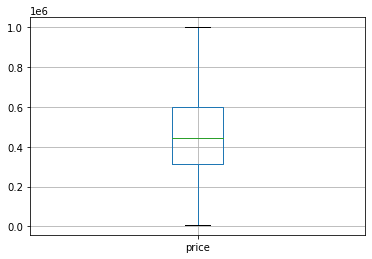

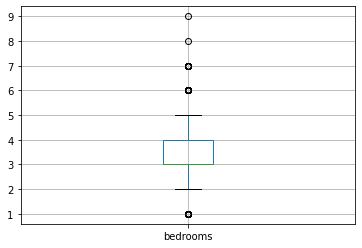

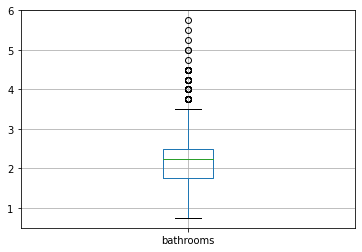

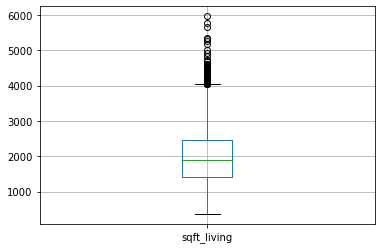

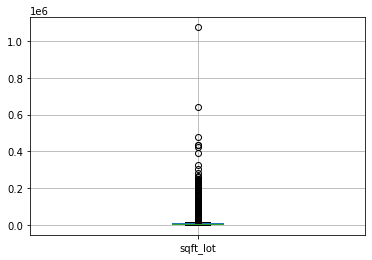

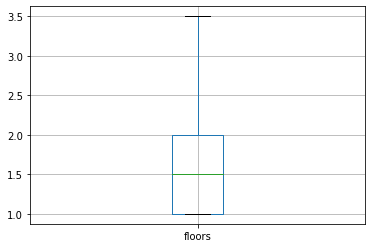

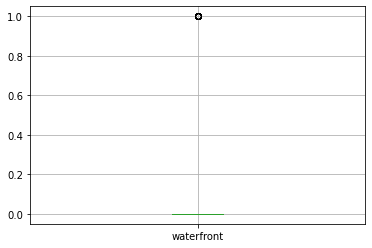

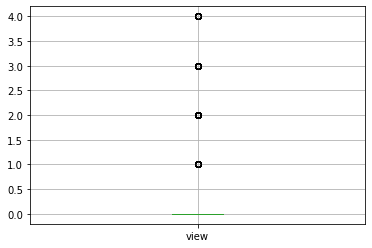

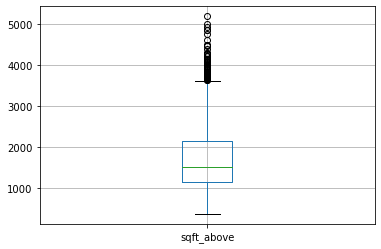

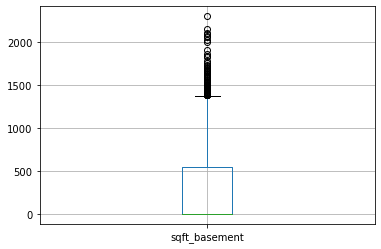

In [19]:
boxplot_viz(data_viz)

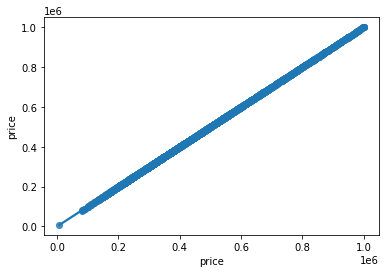

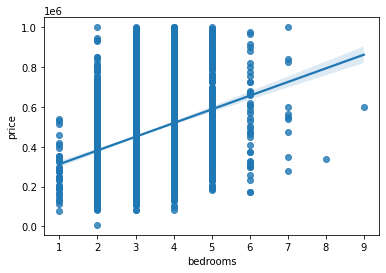

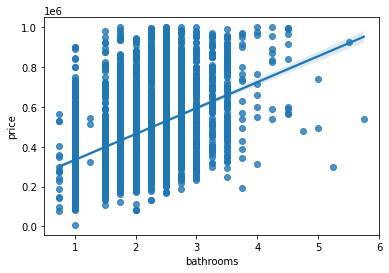

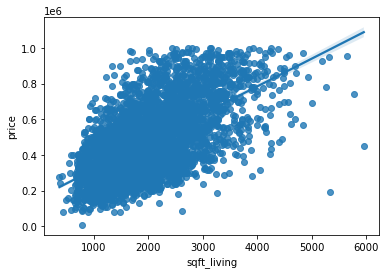

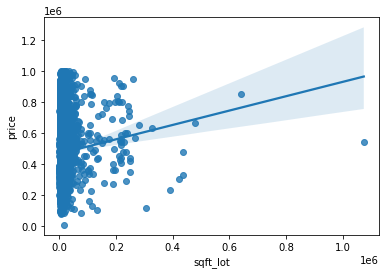

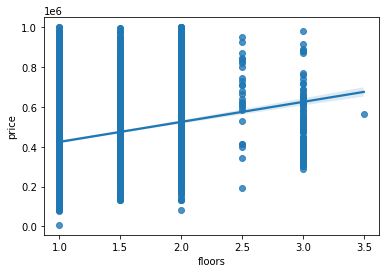

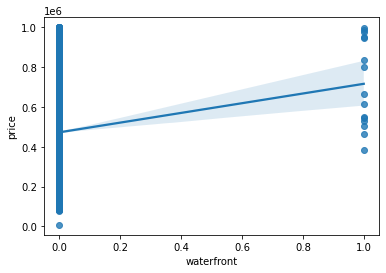

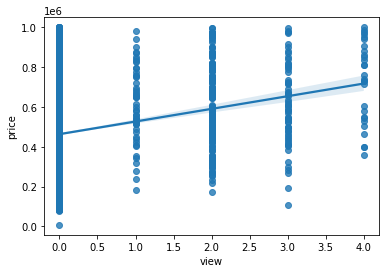

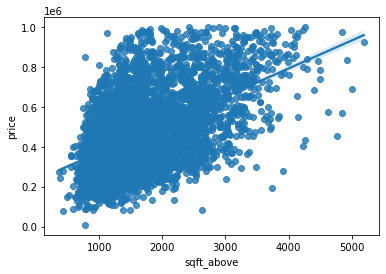

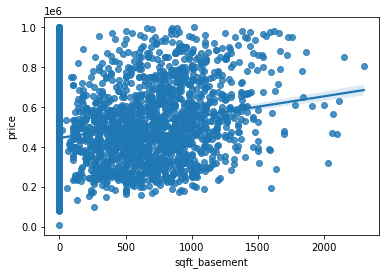

In [20]:
regression_viz(data_viz)

In [21]:
data_viz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4211 entries, 0 to 4599
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4211 non-null   float64
 1   bedrooms       4211 non-null   float64
 2   bathrooms      4211 non-null   float64
 3   sqft_living    4211 non-null   int64  
 4   sqft_lot       4211 non-null   int64  
 5   floors         4211 non-null   float64
 6   waterfront     4211 non-null   int64  
 7   view           4211 non-null   int64  
 8   sqft_above     4211 non-null   int64  
 9   sqft_basement  4211 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 361.9 KB


In [22]:
def distplot_viz(data):
    for i in data:
        plt.figure(figsize=(16,5))
        plt.figure(i)
        sns.distplot(data[i])
        plt.show()

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

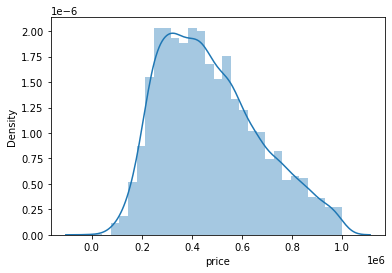

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

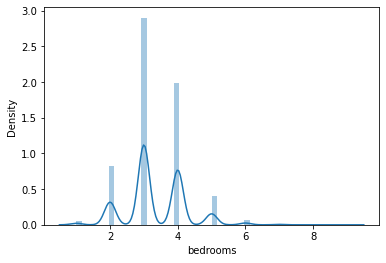

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

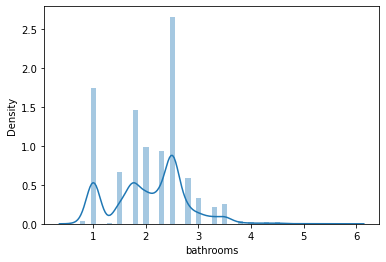

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

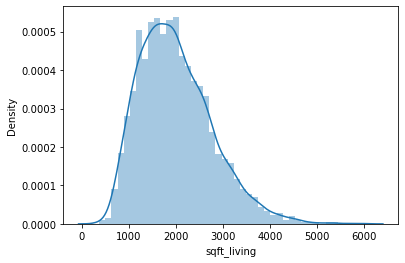

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

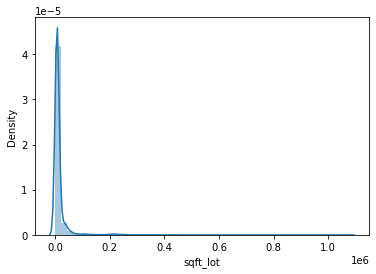

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

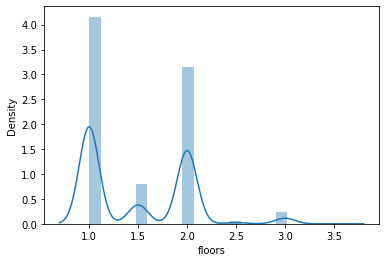

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

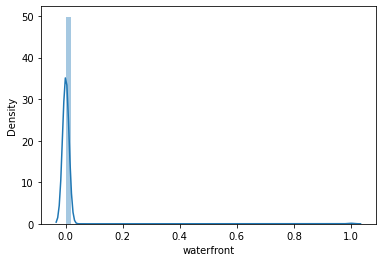

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

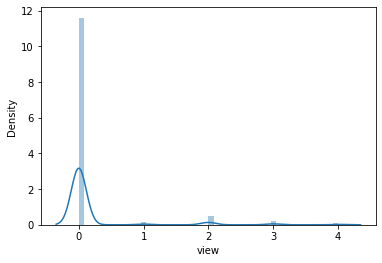

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

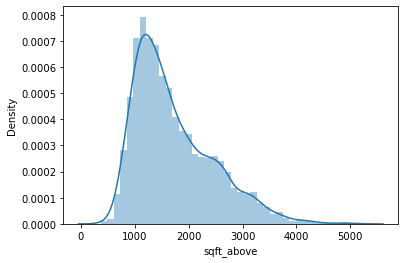

C:\Users\Tsyka\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x360 with 0 Axes>

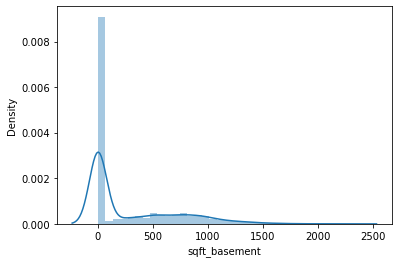

In [23]:
distplot_viz(data_viz)

<h2>Préparation du modèle</h2>

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [25]:
X = data_viz.drop(columns=['price'])
y = data_viz['price']

In [26]:
scaler = MinMaxScaler()
scaler.fit(X)

X=scaler.transform(X)

In [27]:
X

array([[0.25      , 0.15      , 0.17352415, ..., 0.        , 0.20124481,
        0.        ],
       [0.25      , 0.25      , 0.27906977, ..., 0.        , 0.32365145,
        0.        ],
       [0.25      , 0.3       , 0.29159213, ..., 0.        , 0.13070539,
        0.43478261],
       ...,
       [0.25      , 0.35      , 0.47227191, ..., 0.        , 0.54771784,
        0.        ],
       [0.375     , 0.25      , 0.30769231, ..., 0.        , 0.14522822,
        0.44347826],
       [0.25      , 0.35      , 0.20035778, ..., 0.        , 0.23236515,
        0.        ]])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [29]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.3875472782849858

In [30]:
reg.predict(X_test)

array([683730.39565471, 324806.86033922, 467222.11036943, ...,
       456464.27013831, 564095.44633519, 536373.54537261])

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor

In [32]:
model_RF_reg = RandomForestRegressor()
model_KN_reg = KNeighborsRegressor()
model_SGD_reg = SGDRegressor()
model_DT_reg = DecisionTreeRegressor()
model_lin_reg = LinearRegression()

In [33]:
def accuracy(model):
    model.fit(X_train, y_train)
    score = model.score(X_test,y_test)
    return score

In [34]:
models=[model_RF_reg, model_KN_reg, model_SGD_reg, model_DT_reg, model_lin_reg]

In [35]:
for model in models:
    print(f'Le score du model {model} est de {accuracy(model)}')    

Le score du model RandomForestRegressor() est de 0.4000018254892451
Le score du model KNeighborsRegressor() est de 0.35053821509439775
Le score du model SGDRegressor() est de 0.38580289469611573
Le score du model DecisionTreeRegressor() est de -0.0835975273667382
Le score du model LinearRegression() est de 0.39113112649269655


In [36]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [37]:
model_lin_reg.fit(X_train,y_train)

LinearRegression()

In [38]:
y_pred = model_lin_reg.predict(X_test)

In [39]:
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

127595.31805332
24494902677.364746
0.39113112649269655


In [44]:
def prediction_house(X):
    print("5")
    X_test = X
    pred = reg.predict(X_test)
    print("6")
    return pred.tolist()

In [45]:
prediction_house([[1,1,1,1,1,1,1,1,1]])

5
6


[1343473.2213268788]